# Table of Contents <a id='top'></a> 
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#functions)<br> 
3. [Read Data](#read)<br>
4. [Data Pre-processing](#preprocess)<br>
5. [Exploratory Data Analysis (EDA)](#eda)<br>
    5.1 [Distribution of the target](#dist_target) <br>
    5.2 [Feature-target relationships](#rels) <br>
6. [Analysis](#analysis)<br>
    6.1 Model A: [Predict the mean (baseline)](#mean) <br>
    6.2 Model B: [Linear Regression](#SLR) <br>
    6.3 Model C: [Feed Forward Neural Network (FFNN)](#FFNN) <br>
    6.4 Model D: [Neural Network with Embeddings](#NNE) <br>
    6.5 Model E: [Convolutional Neural Network (CNN)](#CNN) <br>
    6.6 Model F: [Recurrent Neural Network (RNN)](#RNN) <br>
7. [Evaluation](#evaluation)<br>                          
                                                        [Note that hyperlinks will not work if viewing in GitHub]

---
## Step 1: Import Packages <a id='imports'></a> 
[jump to top](#top)<br>

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random
pd.set_option("display.max_columns", None)


# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from IPython.display import Image

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# statsmodels
import statsmodels.api as sm

--- 
## Step 2: Define Functions <a id='functions'></a> 
[jump to top](#top)<br>

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.ylabel('MSE (Point Differential)')
    plt.legend()
    plt.grid(True)

In [3]:
def train_test_data(df):

    season_ids = ['season_id_22004.0',
                  'season_id_22005.0',
                  'season_id_22006.0',
                  'season_id_22007.0',
                  'season_id_22008.0',
                  'season_id_22009.0',
                  'season_id_22010.0',
                  'season_id_22011.0',
                  'season_id_22012.0',
                  'season_id_22013.0',
                  'season_id_22014.0',
                  'season_id_22015.0',
                  'season_id_22016.0',
                  'season_id_22017.0',
                  'season_id_22018.0',
                  'season_id_22019.0',
                  'season_id_22020.0',
                  'season_id_22021.0']

    for season_id in season_ids:
        season_df = df.loc[df[season_id] == 1,:]
        num_rows = season_df.shape[0]

        season_train = season_df.iloc[:int(np.floor(num_rows*0.6)),:]
        season_val   = season_df.iloc[int(np.floor(num_rows*0.6)):int(np.floor(num_rows*0.8)),:]
        season_test  = season_df.iloc[int(np.floor(num_rows*0.8)):,:]
        
        X_szn_train = season_train.drop(columns = ['point_differential'])
        X_szn_val   = season_val.drop(columns = ['point_differential'])
        X_szn_test  = season_test.drop(columns = ['point_differential'])
        
        y_szn_train = season_train['point_differential']
        y_szn_val   = season_val['point_differential']
        y_szn_test  = season_test['point_differential']
        
        if season_id == 'season_id_22004.0':
            X_train = X_szn_train
            X_val   = X_szn_val
            X_test  = X_szn_test
            
            y_train = y_szn_train
            y_val   = y_szn_val
            y_test  = y_szn_test
        else:
            X_train = pd.concat([X_train, X_szn_train])
            X_val    = pd.concat([X_val, X_szn_val])
            X_test  = pd.concat([X_test, X_szn_test])

            y_train = pd.concat([y_train, y_szn_train])
            y_val   = pd.concat([y_val, y_szn_val])
            y_test  = pd.concat([y_test, y_szn_test])
        
    
    return X_train, X_val, X_test, y_train, y_val, y_test

---
## Step 3: Read Data <a id='read'></a> 
[jump to top](#top)<br>

In [4]:
### main dataframe of interest for model building

df = pd.read_csv("home_data_w_adv_stats_2.csv")
print("Shape of data:", df.shape)
df.head()

Shape of data: (20868, 137)


,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,point_differential_past_home,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,point_differential_past_away,point_differential_history_home,E_OFF_RATING_home,OFF_RATING_home,E_DEF_RATING_home,DEF_RATING_home,E_NET_RATING_home,NET_RATING_home,AST_PCT_home,AST_TOV_home,AST_RATIO_home,OREB_PCT_home,DREB_PCT_home,REB_PCT_home,E_TM_TOV_PCT_home,TM_TOV_PCT_home,EFG_PCT_home,TS_PCT_home,USG_PCT_home,E_USG_PCT_home,E_PACE_home,PACE_home,PACE_PER40_home,POSS_home,PIE_home,E_OFF_RATING_away,OFF_RATING_away,E_DEF_RATING_away,DEF_RATING_away,E_NET_RATING_away,NET_RATING_away,AST_PCT_away,AST_TOV_away,AST_RATIO_away,OREB_PCT_away,DREB_PCT_away,REB_PCT_away,E_TM_TOV_PCT_away,TM_TOV_PCT_away,EFG_PCT_away,TS_PCT_away,USG_PCT_away,E_USG_PCT_away,E_PACE_away,PACE_away,PACE_PER40_away,POSS_away,PIE_away,game_id,away_team,matchup,point_differential,season_id_22004.0,season_id_22005.0,season_id_22006.0,season_id_22007.0,season_id_22008.0,season_id_22009.0,season_id_22010.0,season_id_22011.0,season_id_22012.0,season_id_22013.0,season_id_22014.0,season_id_22015.0,season_id_22016.0,season_id_22017.0,season_id_22018.0,season_id_22019.0,season_id_22020.0,season_id_22021.0,home_team_1610612737.0,home_team_1610612738.0,home_team_1610612739.0,home_team_1610612740.0,home_team_1610612741.0,home_team_1610612742.0,home_team_1610612743.0,home_team_1610612744.0,home_team_1610612745.0,home_team_1610612746.0,home_team_1610612747.0,home_team_1610612748.0,home_team_1610612749.0,home_team_1610612750.0,home_team_1610612751.0,home_team_1610612752.0,home_team_1610612753.0,home_team_1610612754.0,home_team_1610612755.0,home_team_1610612756.0,home_team_1610612757.0,home_team_1610612758.0,home_team_1610612759.0,home_team_1610612760.0,home_team_1610612761.0,home_team_1610612762.0,home_team_1610612763.0,home_team_1610612764.0,home_team_1610612765.0,home_team_1610612766.0
0,35.0,83.0,0.422,4.0,17.0,0.235,17.0,29.0,0.586,19.0,26.0,45.0,25.0,10.0,5.0,21.0,30.0,91.0,-12.0,30.5,71.0,0.4295,5.5,14.5,0.3875,17.0,23.0,0.7405,8.5,28.5,37.0,12.0,4.0,3.5,16.0,23.0,83.5,-7.5,NaN,93.1,92.9,106.8,105.1,-13.8,-12.2,0.714,1.19,17.6,0.423,0.604,0.510,21.481,21.4,0.446,0.475,1.0,0.200,97.08,98.00,81.67,98.0,0.396,94.25,95.9,106.15,103.95,-11.9,-8.05,0.3855,0.77,10.9,0.287,0.689,0.497,18.054,18.45,0.4685,0.5145,1.0,0.200,87.17,87.25,72.705,87.0,0.380,20400023.0,1.610613e+09,MEM vs. HOU,-8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,33.0,69.0,0.478,5.0,17.0,0.294,24.0,32.0,0.750,10.0,25.0,35.0,23.0,9.0,3.0,19.0,27.0,95.0,-3.0,43.0,93.0,0.4620,4.0,17.0,0.2350,19.0,26.0,0.7310,11.0,36.0,47.0,24.0,9.0,5.0,14.0,28.0,109.0,5.0,NaN,103.2,103.3,103.6,107.7,-0.5,-4.4,0.697,1.21,18.4,NaN,0.638,NaN,20.634,20.7,0.514,0.572,1.0,0.198,93.32,91.50,76.25,92.0,0.506,101.50,101.9,98.20,98.10,3.3,3.80,0.5580,1.71,16.8,0.296,0.750,0.519,13.031,13.10,0.4840,0.5220,1.0,0.198,88.30,88.14,73.450,107.0,0.529,20400022.0,1.610613e+09,BOS vs. IND,-6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37.0,97.0,0.381,3.0,14.0,0.214,17.0,21.0,0.810,19.0,34.0,53.0,25.0,9.0,6.0,12.0,22.0,94.0,2.0,44.0,75.0,0.5870,2.0,7.0,0.2860,12.0,16.0,0.7500,7.0,34.0,41.0,28.0,4.0,6.0,17.0,23.0,102.0,22.0,NaN,94.7,96.9,95.6,94.8,-0.9,2.1,0.676,2.08,17.5,0.344,0.729,0.514,12.092,12.4,0.397,0.442,1.0,0.196,88.52,87.85,73.21,97.0,0.480,110.80,114.6,88.10,90.90,22.7,23.70,0.6360,1.65,22.0,0.333,0.692,0.553,18.470,19.10,0.6000,0.6220,1.0,0.196,91.42,88.50,73.750,89.0,0.724,20400040.0,1.610613e+09,DEN vs. UTA,-24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28.0,74.0,0.378,2.0,8.0,0.250,19.0,27.0,0.

In [5]:
### disregard this dataframe, it is only needed because of an error exporting the column team_id_away, and this 
### column is only necessary for one visualization in the EDA

game = pd.read_csv("Archive/Cams_stuff/data/game.csv")
print(game.shape)
game.head()

(64292, 55)


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min_home,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,min_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,NaN,NaN,NaN,NaN,NaN,16.0,29.0,0.552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,0,24.0,NaN,NaN,NaN,NaN,NaN,20.0,26.0,0.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,2,0
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,59.0,0.339,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,56,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,0,16.0,72.0,0.222,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,51,-5,0
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,6,0,1610612738,BOS,Boston Celtics,BOS @ PRO,L,0,21.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,-6,0
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,63,16,0,1610612752,NYK,New York Knicks,NYK @ CHS,L,0,16.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,47,-16,0
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,-17,0,1610610036,WAS,Washington Capitols,WAS @ DEF,W,0,18.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,17,0


In [6]:
### retrieve the team_id_home and team_id_away that we'd dropped in the Data Preparation notebook

team_ids = pd.merge(left = df[["game_id"]], right = game[["game_id", "team_id_away", "team_id_home"]], on = "game_id")
df = pd.merge(left = df, right = team_ids, on = "game_id")

---
## Step 4: Data Pre-processing <a id='preprocess'></a> 
[jump to top](#top)<br>

In [7]:
# sort by game_id
df.sort_values(by = ['game_id'], axis = 0, inplace = True)

# drop game_id and matchup
df.drop(columns = ['game_id','matchup', 'away_team'], inplace = True)
# we will also drop team_id_home and team_id_away before modeling, but we need them for a plot in the EDA

# drop redundant columns (columns that are pure linear combinations of other columns)
df.drop(columns = ['fga_home', 'fg3a_home', 'fta_home', 'reb_home',
                   'fga_away', 'fg3a_away', 'fta_away', 'reb_away'], inplace = True)

# drop null values
df.dropna(axis = 0, inplace = True)

In [8]:
### standardize the features

X_train, X_val, X_test, y_train, y_val, y_test = train_test_data(df)

sc = StandardScaler()
sc.fit(pd.concat([X_train,X_val], axis = 0))

X_train_std = sc.transform(X_train)
X_val_std   = sc.transform(X_val)
X_test_std  = sc.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_val_std   = pd.DataFrame(X_val_std, columns = X_val.columns)
X_test_std  = pd.DataFrame(X_test_std, columns = X_test.columns)

In [9]:
### standardize the target

sc_y = StandardScaler()
sc_y.fit(np.concatenate((np.array(y_train).reshape(-1,1),np.array(y_val).reshape(-1,1))))

y_train_std = sc_y.transform(np.array(y_train).reshape(-1,1))
y_val_std   = sc_y.transform(np.array(y_val).reshape(-1,1))
y_test_std  = sc_y.transform(np.array(y_test).reshape(-1,1))

y_train_std = pd.DataFrame({'point_differential': y_train_std.flatten()})
y_val_std   = pd.DataFrame({'point_differential': y_val_std.flatten()})
y_test_std  = pd.DataFrame({'point_differential': y_test_std.flatten()})

In [10]:
# check shape of data
print('Shape of X_train_std', X_train_std.shape)
print('Shape of y_train_std', y_train_std.shape)
print("-"*50)

print('Shape of X_val_std', X_val_std.shape)
print('Shape of y_val_std', y_val_std.shape)
print("-"*50)

print('Shape of X_test_std', X_test_std.shape)
print('Shape of y_test_std', y_test_std.shape)

Shape of X_train_std (11914, 127)
Shape of y_train_std (11914, 1)
--------------------------------------------------
Shape of X_val_std (3975, 127)
Shape of y_val_std (3975, 1)
--------------------------------------------------
Shape of X_test_std (3981, 127)
Shape of y_test_std (3981, 1)


In [11]:
### outliers 

def find_outliers_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df < (q1 - 1.5*IQR)) | (df > (q3 + 1.5*IQR)))]
    return outliers

outliers = find_outliers_IQR(y_train_std["point_differential"])
print("Number of outliers to be dropped:   ", len(outliers))
print("Percent of training data to be lost:", f"{round(100*len(outliers)/len(y_train_std), 2)}%")

Number of outliers to be dropped:    107
Percent of training data to be lost: 0.9%


In [12]:
# drop the outliers from the training data

q1 = y_train_std["point_differential"].quantile(0.25)
q3 = y_train_std["point_differential"].quantile(0.75)
IQR = q3 - q1

y_train_std = y_train_std[(y_train_std["point_differential"] >= (q1 - 1.5*IQR)) & 
                   (y_train_std["point_differential"] <= (q3 + 1.5*IQR))]

# adjust y_train, X_train_std, and y_train to reflect the dropped observations
y_train = pd.DataFrame(y_train.reset_index(drop = True)).loc[y_train_std.index, :]
X_train_std = X_train_std.loc[y_train_std.index, :] # only important one of the three
X_train = X_train.reset_index(drop = True).loc[y_train_std.index, :]

# reset the index of each dataframe because the dropping messes it up
y_train_std.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
X_train_std.reset_index(drop = True, inplace = True)
X_train.reset_index(drop = True, inplace = True)

We made the decision to drop outliers in the target variable from the training data. That is, we drop rows for which the value of point differential is outside of $[q1 - 1.5\times IQR, q3 + 1.5\times IQR]$ where q1 and q3 are the first and third quartiles of point differential, and IQR is the interquartile range: $q3 - q1$. It will be clear in the EDA that this is almost equivalent to dropping all observations further than 3 standard deviations from the mean of point differential. 

---
## Step 5: Exploratory Data Analysis <a id='eda'></a> 
[jump to top](#top)<br>

#### Distribution of the target <a id='dist_target'></a> 
[jump to top](#top)<br>

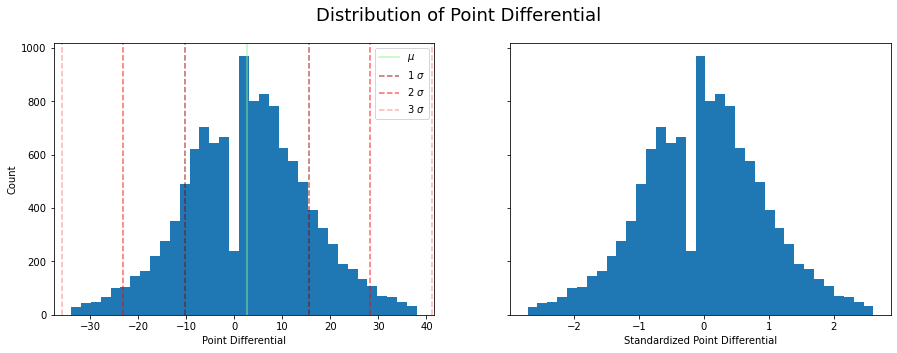

In [13]:
### distribution of the target (point differential)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (15, 5))

fig.suptitle("Distribution of Point Differential", fontsize = 18)
ax1.hist(y_train, bins = 35)
ax1.axvline(x = y_train["point_differential"].mean(), 
            color = "lightgreen", 
            label = r"$\mu$", 
            alpha = 0.6)
ax1.axvline(x = y_train["point_differential"].mean() + y_train["point_differential"].std(), 
            color = "darkred", 
            linestyle = "--", 
            label = r"1 $\sigma$", 
            alpha = 0.6)
ax1.axvline(x = y_train["point_differential"].mean() - y_train["point_differential"].std(), 
            color = "darkred", 
            linestyle = "--", 
            alpha = 0.6)
ax1.axvline(x = y_train["point_differential"].mean() + 2*y_train["point_differential"].std(), 
            color = "red", 
            linestyle = "--", 
            label = r"2 $\sigma$", 
            alpha = 0.6)
ax1.axvline(x = y_train["point_differential"].mean() - 2*y_train["point_differential"].std(), 
            color = "red", 
            linestyle = "--", 
            alpha = 0.6)
ax1.axvline(x = y_train["point_differential"].mean() + 3*y_train["point_differential"].std(), 
            color = "red", 
            linestyle = "--", 
            label = r"3 $\sigma$", 
            alpha = 0.3)
ax1.axvline(x = y_train["point_differential"].mean() - 3*y_train["point_differential"].std(), 
            color = "red", 
            linestyle = "--", 
            alpha = 0.3)
ax1.set_xlabel("Point Differential")
ax1.set_ylabel("Count")
ax1.legend()
ax2.hist(y_train_std, bins = 35)
ax2.set_xlabel("Standardized Point Differential")
plt.show()

#### Feature-target relationships <a id='rels'></a> 
[jump to top](#top)<br>

*See the Decision Tree notebook for a detailed evaluation of feature importance*

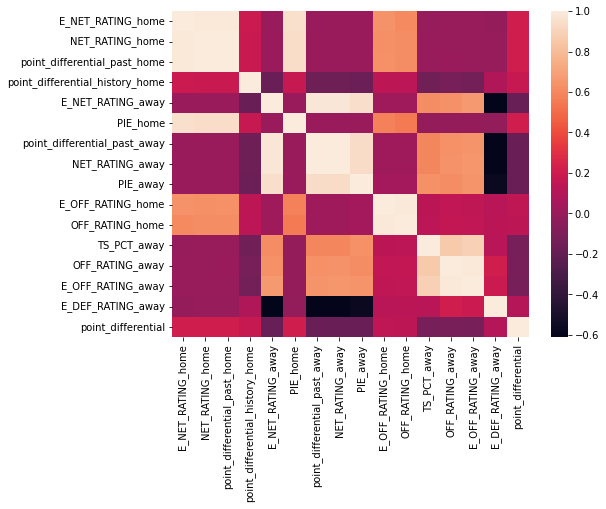

In [14]:
### most important features as identified by the Decision Tree notebook

# specify the features identified by the decision tree
important_features = ["E_NET_RATING_home", 
                      "NET_RATING_home", 
                      "point_differential_past_home", 
                      "point_differential_history_home", 
                      "E_NET_RATING_away", 
                      "PIE_home", 
                      "point_differential_past_away", 
                      "NET_RATING_away",
                      "PIE_away", 
                      "E_OFF_RATING_home", 
                      "OFF_RATING_home", 
                      "TS_PCT_away", 
                      "OFF_RATING_away", 
                      "E_OFF_RATING_away", 
                      "E_DEF_RATING_away"] 

# all pairs correlation (target at the bottom: point_differential)
plt.figure(figsize=(8,6))
sns.heatmap(pd.concat([X_train_std[important_features], y_train_std], axis = 1).corr());

In [15]:
# print the values corresponding to the bottom row of the correlation heatmap shown above (in descending order)

corr = pd.concat([X_train_std[important_features], y_train_std], axis = 1).corr()
round(corr[["point_differential"]].sort_values(by = "point_differential", ascending=False), 2)

,point_differential
point_differential,1.00
E_NET_RATING_home,0.22
point_differential_past_home,0.22
NET_RATING_home,0.22
PIE_home,0.21
point_differential_history_home,0.18
E_OFF_RATING_home,0.15
OFF_RATING_home,0.14
E_DEF_RATING_away,0.10
OFF_RATING_away,-0.12


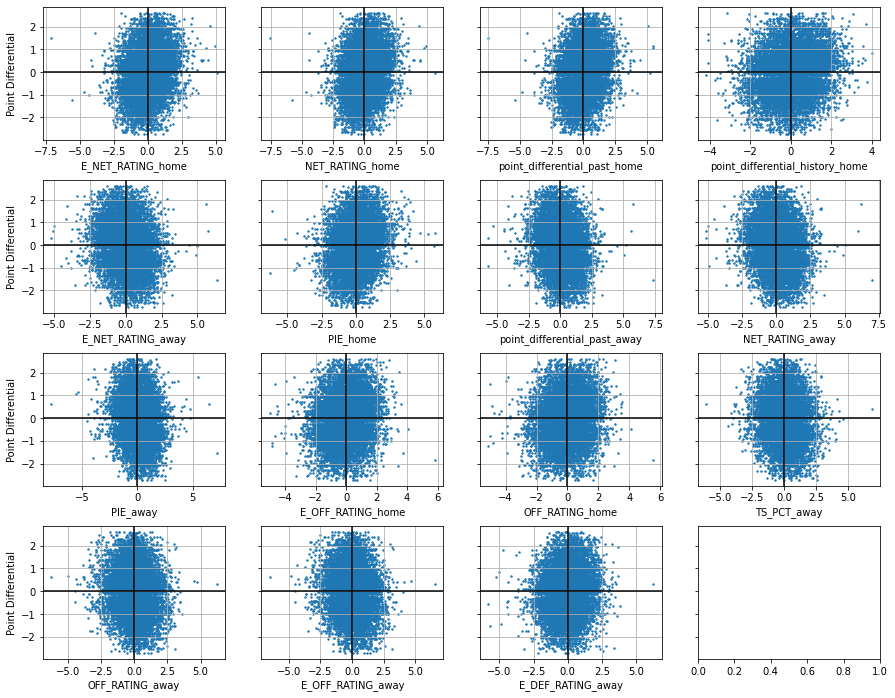

In [16]:
### scatterplots between the target and each of the features identified above

# make a nested list for graphing purposes
important_features = [["E_NET_RATING_home", 
                      "NET_RATING_home", 
                      "point_differential_past_home", 
                      "point_differential_history_home"], 
                      ["E_NET_RATING_away", 
                      "PIE_home", 
                      "point_differential_past_away", 
                      "NET_RATING_away"],
                      ["PIE_away", 
                      "E_OFF_RATING_home", 
                      "OFF_RATING_home", 
                      "TS_PCT_away"], 
                      ["OFF_RATING_away", 
                      "E_OFF_RATING_away", 
                      "E_DEF_RATING_away"]]

fig, axs = plt.subplots(nrows=4, ncols=4, figsize = (15, 12), sharey=True, gridspec_kw={'hspace': 0.3})
for i in range(4):
    for j in range(4):
        if (i==3) & (j==3):
            pass
        else:
            feature = important_features[i][j]
            axs[i][j].scatter(y = y_train_std, x = X_train_std[feature], s = 2)
            axs[i][j].set_xlabel(f'{feature}')
            if j == 0:
                axs[i][j].set_ylabel("Point Differential")
            axs[i][j].grid()
            axs[i][j].axvline(x = 0, color = "black")
            axs[i][j].axhline(y = 0, color = "black")           

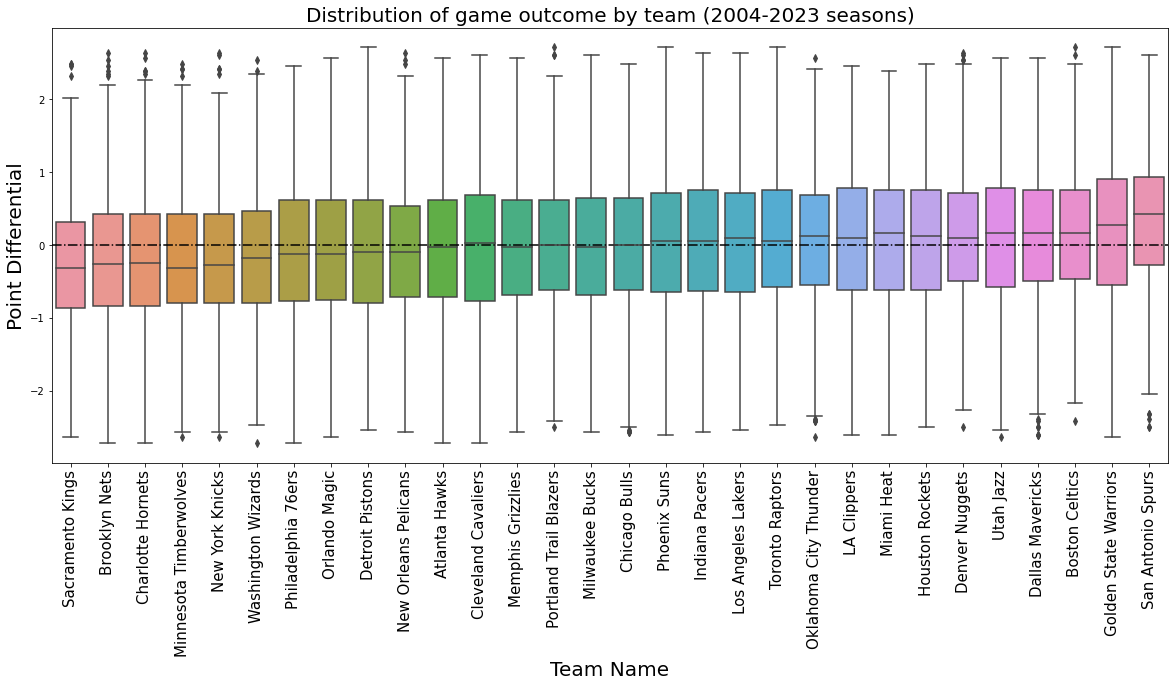

In [17]:
### disaggregate the distribution of point differential by team

# match team id to team name
recent = game.loc[game["season_id"]>=22004]
team_dict = {}
for team_id in recent.team_id_home.unique():
    temp_df = recent[["team_id_home", "team_name_home"]].loc[recent["team_id_home"]==team_id]
    team_names = list(temp_df["team_name_home"].unique())
    team_dict[team_id] = team_names

# grab point_differential, and home and away team ids then wrangle them around to create a usable dataframe, d
a = pd.concat([y_train_std["point_differential"], X_train[["team_id_home", "team_id_away"]]], axis = 1)
a["point_differential_away"] = -a["point_differential"]
b = a[["point_differential", "team_id_home"]].rename(columns={"team_id_home":"team_id"})
c = a[["point_differential_away", "team_id_away"]].rename(columns={"point_differential_away":"point_differential", 
                                                                   "team_id_away":"team_id"})
d = pd.concat([b, c], axis = 0)
d["team_name"] = [team_dict[t_id][-1] for t_id in d.reset_index()["team_id"]]

# order the teams in ascending order by their mean point_differential
point_differential_mean_list = d.point_differential.groupby(d.team_name).agg(np.mean).sort_values().index

# create a box and whisker plot
fig, ax = plt.subplots(figsize = (20, 8))
sns.boxplot(x = "team_name", y = "point_differential", data = d, order = point_differential_mean_list)
plt.axhline(y = 0, color = "black", linestyle = "-.")
plt.xlabel("Team Name", size = 20)
plt.ylabel("Point Differential", size = 20)
plt.title("Distribution of game outcome by team (2004-2023 seasons)", size = 20)
plt.xticks(rotation=90, size = 15);

Remember to drop the team_ids before analysis

In [18]:
# drop the team_id columns because they are not necessary for the modeling

X_train_std.drop(columns=["team_id_away", "team_id_home"], inplace = True)
X_val_std.drop(columns=["team_id_away", "team_id_home"], inplace = True)
X_test_std.drop(columns=["team_id_away", "team_id_home"], inplace = True)

---
## Step 6: Analysis <a id='analysis'></a> <a id='top_of_analysis'></a>
[jump to top](#top)<br>

### Table of Contents (Analysis)  

* 6.1 Model A: **Predict the mean (baseline)** [__](#mean) <br>
* 6.2 Model B: **Linear Regression** [__](#SLR) <br>
    - 6.2.1 [Regression 1: Lags of point_differential](#reg1)<br>
    - 6.2.2 [Regression 2: 15 best features](#reg2)<br>
    - 6.2.3 [Regression 3: All the features](#reg3)<br>
* 6.3 Model C: **Feed Forward Neural Network (FFNN)** [__](#FFNN)<br>
    - 6.3.1 [FFNN 1](#FFNN1)<br>
    - 6.3.2 [FFNN 2](#FFNN2)<br>
    - 6.3.3 [FFNN 3](#FFNN3)<br>
    - 6.3.4 [FFNN 4](#FFNN4)<br>
    - 6.3.5 [FFNN 5](#FFNN5)<br>
    - 6.3.6 [FFNN 6](#FFNN6)<br>
    - 6.3.7 [FFNN 7](#FFNN7)<br>
    - 6.3.8 [FFNN 8](#FFNN8)<br>
    - 6.3.9 [FFNN 9](#FFNN9)<br>
    - 6.3.10 [FFNN 10](#FFNN10)<br>
    - 6.3.11 [FFNN 11](#FFNN11)<br>
    - 6.3.12 [FFNN 12](#FFNN12)<br>
* 6.4 Model D: **Neural Network with Embeddings** [__](#NNE)<br>
    - 6.4.1 [NNE 1](#NNE1)<br>
* 6.5 Model E: **Convolutional Neural Network (CNN)** [__](#CNN) <br>
    - 6.5.1 [CNN 1](#CNN1)<br>
* 6.6 Model F: **Recurrent Neural Network (RNN)** [__](#RNN) <br>

**Table of results**

In [19]:
base_line = ["Baseline", "-", "-", "-", "-", "-", "-", "-", "-", "MSE", 0.9, 1.05]
LR_1 = ["LR 1", "-", "-", "-", "-", "-", "-", "-", "-", "MSE", 0.82, 0.93]
LR_2 = ["LR 2", "-", "-", "-", "-", "-", "-", "-", "-", "MSE", 0.82, 0.93]
LR_3 = ["LR 3", "-", "-", "-", "-", "-", "-", "-", "-", "MSE", 0.8, 0.92]
FFNN_1 = ["FFNN 1", "0.1", "Adamax", 0.3, 2, "relu", 50, 3, [256, 128, 64], "MSE", 0.86, 0.99]
FFNN_2 = ["FFNN 2", "0.01", "Adamax", 0.3, 2, "relu", 50, 3, [256, 128, 64], "MSE", 0.53, 1.01]
FFNN_3 = ["FFNN 3", "0.01", "Adamax", 0.5, 2, "relu", 50, 3, [256, 128, 64], "MSE", 0.68, 0.96]
FFNN_4 = ["FFNN 4", "0.1", "Adamax", 0.5, 2, "relu", 50, 3, [128, 64, 32], "MSE", 0.86, 0.97]
FFNN_5 = ["FFNN 5", "0.01", "Adamax", 0.5, 2, "relu", 50, 3, [65, 32, 16], "MSE", 0.76, 0.94]
FFNN_6 = ["FFNN 6", "0.01", "Adamax", 0.7, 2, "relu", 50, 3, [65, 32, 16], "MSE", 0.81, 0.95]
FFNN_7 = ["FFNN 7", "0.01", "Adamax", 0.7, 2, "relu", 100, 3, [65, 32, 16], "MSE", 0.79, 0.93]
FFNN_8 = ["FFNN 8", "0.01", "Adamax", 0.7, 2, "sigmoid", 100, 3, [65, 32, 16], "MSE", 0.77, 0.93]
FFNN_9 = ["FFNN 9", "0.01", "SGD", 0.7, 2, "relu", 100, 3, [65, 32, 16], "MSE", 0.83, 0.98]
FFNN_10 = ["FFNN 10", "0.001", "SGD", 0.7, 2, "relu", 100, 3, [65, 32, 16], "MSE", 0.9, 1.03]
FFNN_11 = ["FFNN 11", "0.01", "Adamax", 0.9, 2, "sigmoid", 100, 3, [65, 32, 16], "MSE", 0.84, 0.98]
FFNN_12 = ["FFNN 12", "0.01", "Adamax", 0.7, 2, "relu", 100, 4, [65, 32, 16, 8], "MSE", 0.82, 0.94]
NNE_1 = ["NNE 1", "0.01", "Adamax", 0.5, 2, "relu", 50, "3 + embedding layer + pooling layer", [130, 65, 32], "MSE", 0.9, 1.05]
CNN_1 = ["CNN 1", "0.1", "Adamax", 0.5, 3, "relu", 50, "3 convolutional layers + 3 maxpooling layers", [128, 64, 32], "MSE", 0.91, 1.05]

pd.DataFrame([base_line, 
              LR_1, 
              LR_2, 
              LR_3, 
              FFNN_1, 
              FFNN_2, 
              FFNN_3, 
              FFNN_4,
              FFNN_5,
              FFNN_6,
              FFNN_7,
              FFNN_8,
              FFNN_9,
              FFNN_10,
              FFNN_11,
              FFNN_12,
              NNE_1, 
              CNN_1], 
             columns = ["Model", 
                       "learning rate", 
                       "optimizer", 
                       "dropout rate", 
                       "dropout layers", 
                       "activation", 
                       "epochs", 
                       "hidden layers", 
                       "hidden layer dims", 
                       "loss function", 
                       "Training loss", 
                       "Validation loss"])

,Model,learning rate,optimizer,dropout rate,dropout layers,activation,epochs,hidden layers,hidden layer dims,loss function,Training loss,Validation loss
0,Baseline,-,-,-,-,-,-,-,-,MSE,0.90,1.05
1,LR 1,-,-,-,-,-,-,-,-,MSE,0.82,0.93
2,LR 2,-,-,-,-,-,-,-,-,MSE,0.82,0.93
3,LR 3,-,-,-,-,-,-,-,-,MSE,0.80,0.92
4,FFNN 1,0.1,Adamax,0.3,2,relu,50,3,"[256, 128, 64]",MSE,0.86,0.99
5,FFNN 2,0.01,Adamax,0.3,2,relu,50,3,"[256, 128, 64]",MSE,0.53,1.01
6,FFNN 3,0.01,Adamax,0.5,2,relu,50,3,"[256, 128, 64]",MSE,0.68,0.96
7,FFNN 4,0.1,Adamax,0.5,2,relu,50,3,"[128, 64, 32]",MSE,0.86,0.97
8,FFNN 5,0.01,Adamax,0.5,2,relu,50,3,"[65, 32, 16]",MSE,0.76,0.94
9,FFNN 6,0.01,Adamax,0.7,2,relu,50,3,"[65, 32, 16]",MSE,0.81,0.95


### Model A: Predict the mean of the training target (point differential)  <a id='mean'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis)<br>

In [20]:
y_pred = np.mean(y_train_std)
y_pred

/Users/cameronwright/Desktop/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


point_differential   -0.004559
dtype: float64

In [21]:
# validation

print("Training MSE:", round(np.mean((y_train_std - y_pred)**2)[0], 2))
# print("Training RMSE:", round(np.sqrt(np.mean((y_train_std - y_pred)**2))[0], 2))
# print("Training MAE:", round(np.mean(np.abs(y_train_std - y_pred))[0], 2))
print("-"*50)
print("Validation MSE:", round(np.mean((y_val_std - y_pred)**2)[0], 2))
# print("Validation RMSE:", round(np.sqrt(np.mean((y_val_std - y_pred)**2))[0], 2))
# print("Validation MAE:", round(np.mean(np.abs(y_val_std - y_pred))[0], 2))

Training MSE: 0.9
--------------------------------------------------
Validation MSE: 1.05


In [22]:
baseline_mse = round(np.mean(np.square(y_test_std - y_pred)),2)

*How can we make these results more interpretable? It's confusing because the `y` variable has been stardardized*

### Model B: Linear Regression <a id='SLR'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis) <br>

#### Regression 1: Lags of point_differential <a id='reg1'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [23]:
# grab the point_differential features and add a constant column for statsmodels

point_differential_lags_train = X_train_std[["point_differential_history_home", 
                                             "point_differential_past_home", 
                                             "point_differential_past_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_train_std),)))
point_differential_lags_train = pd.concat([ones, point_differential_lags_train], axis = 1)
point_differential_lags_train = point_differential_lags_train.rename(columns={0:"constant"})

In [24]:
short_reg = sm.OLS(y_train_std, point_differential_lags_train).fit()
print(short_reg.summary())

                            OLS Regression Results                            
Dep. Variable:     point_differential   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     393.9
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          7.58e-244
Time:                        17:11:15   Log-Likelihood:                -15599.
No. Observations:               11807   AIC:                         3.121e+04
Df Residuals:                   11803   BIC:                         3.124e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
constant  

In [25]:
# predictions

# training predictions
y_pred_train = short_reg.predict(point_differential_lags_train)

# validation predictions
point_differential_lags_val = X_val_std[["point_differential_history_home", 
                                         "point_differential_past_home", 
                                         "point_differential_past_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_val_std),)))
point_differential_lags_val = pd.concat([ones, point_differential_lags_val], axis = 1).rename(columns={0:"constant"})

y_pred_val = short_reg.predict(point_differential_lags_val)

In [26]:
# validation

print("Training MSE:", round(np.mean((y_train_std["point_differential"] - y_pred_train)**2), 2))
# print("Training RMSE:", round(np.sqrt(np.mean((y_train_std["point_differential"] - y_pred_train)**2)), 2))
# print("Training MAE:", round(np.mean(np.abs(y_train_std["point_differential"] - y_pred_train)), 2))
print("-"*50)
print("Validation MSE:", round(np.mean((y_val_std["point_differential"] - y_pred_val)**2), 2))
# print("Validation RMSE:", round(np.sqrt(np.mean((y_val_std["point_differential"] - y_pred_val)**2)), 2))
# print("Validation MAE:", round(np.mean(np.abs(y_val_std["point_differential"] - y_pred_val)), 2))

Training MSE: 0.82
--------------------------------------------------
Validation MSE: 0.93


In [27]:
# test
point_differential_lags_test = X_test_std[["point_differential_history_home", 
                                         "point_differential_past_home", 
                                         "point_differential_past_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_test_std),)))
point_differential_lags_test = pd.concat([ones, point_differential_lags_test], axis = 1).rename(columns={0:"constant"})

short_reg_yhat = short_reg.predict(point_differential_lags_test)
short_reg_mse = np.mean(np.square(short_reg_yhat - y_test_std['point_differential']))
print('Test MSE:', round(short_reg_mse,2))

short_reg_mse = round(short_reg_mse,2)

Test MSE: 0.92


#### Regression 2: 15 best features <a id='reg2'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [28]:
# grab the point_differential features and add a constant column for statsmodels

fifteen_best_features_train = X_train_std[["point_differential_history_home", 
                                           "point_differential_past_home", 
                                           "point_differential_past_away", 
                                           "E_NET_RATING_home", 
                                           "NET_RATING_home", 
                                           "PIE_home", 
                                           "E_NET_RATING_away", 
                                           "NET_RATING_away", 
                                           "PIE_away", 
                                           "E_OFF_RATING_home", 
                                           "OFF_RATING_home", 
                                           "TS_PCT_away", 
                                           "E_OFF_RATING_away", 
                                           "E_DEF_RATING_home", 
                                           "EFG_PCT_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_train_std),)))
fifteen_best_features_train = pd.concat([ones, fifteen_best_features_train], axis = 1)
fifteen_best_features_train = fifteen_best_features_train.rename(columns={0:"constant"})

In [29]:
medium_reg = sm.OLS(y_train_std, fifteen_best_features_train).fit()
print(medium_reg.summary())

                            OLS Regression Results                            
Dep. Variable:     point_differential   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     81.10
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.46e-237
Time:                        17:11:15   Log-Likelihood:                -15583.
No. Observations:               11807   AIC:                         3.120e+04
Df Residuals:                   11791   BIC:                         3.132e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
constant  

In [30]:
# predictions

# training predictions
y_pred_train = medium_reg.predict(fifteen_best_features_train)

# validation predictions
fifteen_best_features_val = X_val_std[["point_differential_history_home", 
                                       "point_differential_past_home", 
                                       "point_differential_past_away", 
                                       "E_NET_RATING_home", 
                                       "NET_RATING_home", 
                                       "PIE_home", 
                                       "E_NET_RATING_away", 
                                       "NET_RATING_away", 
                                       "PIE_away", 
                                       "E_OFF_RATING_home", 
                                       "OFF_RATING_home", 
                                       "TS_PCT_away", 
                                       "E_OFF_RATING_away", 
                                       "E_DEF_RATING_home", 
                                       "EFG_PCT_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_val_std),)))
fifteen_best_features_val = pd.concat([ones, fifteen_best_features_val], axis = 1).rename(columns={0:"constant"})

y_pred_val = medium_reg.predict(fifteen_best_features_val)

In [31]:
# validation

print("Training MSE:", round(np.mean((y_train_std["point_differential"] - y_pred_train)**2), 2))
# print("Training RMSE:", round(np.sqrt(np.mean((y_train_std["point_differential"] - y_pred_train)**2)), 2))
# print("Training MAE:", round(np.mean(np.abs(y_train_std["point_differential"] - y_pred_train)), 2))
print("-"*50)
print("Validation MSE:", round(np.mean((y_val_std["point_differential"] - y_pred_val)**2), 2))
# print("Validation RMSE:", round(np.sqrt(np.mean((y_val_std["point_differential"] - y_pred_val)**2)), 2))
# print("Validation MAE:", round(np.mean(np.abs(y_val_std["point_differential"] - y_pred_val)), 2))

Training MSE: 0.82
--------------------------------------------------
Validation MSE: 0.93


In [32]:
# test
fifteen_best_features_test = X_test_std[["point_differential_history_home", 
                                       "point_differential_past_home", 
                                       "point_differential_past_away", 
                                       "E_NET_RATING_home", 
                                       "NET_RATING_home", 
                                       "PIE_home", 
                                       "E_NET_RATING_away", 
                                       "NET_RATING_away", 
                                       "PIE_away", 
                                       "E_OFF_RATING_home", 
                                       "OFF_RATING_home", 
                                       "TS_PCT_away", 
                                       "E_OFF_RATING_away", 
                                       "E_DEF_RATING_home", 
                                       "EFG_PCT_away"]]
ones = pd.DataFrame(np.ones(shape=(len(X_test_std),)))
fifteen_best_features_test = pd.concat([ones, fifteen_best_features_test], axis = 1).rename(columns={0:"constant"})

medium_reg_yhat = medium_reg.predict(fifteen_best_features_test)
medium_reg_mse = np.mean(np.square(medium_reg_yhat - y_test_std['point_differential']))
print('Test MSE:', round(medium_reg_mse,2))

medium_reg_mse = round(medium_reg_mse,2)

Test MSE: 0.91


#### Regression 3: All the features <a id='reg3'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [33]:
ones = pd.DataFrame(np.ones(shape=(len(X_train_std),)))
features_train = pd.concat([ones, X_train_std], axis = 1)
features_train = features_train.rename(columns={0:"constant"})

In [34]:
full_reg = sm.OLS(y_train_std, features_train).fit()
print(full_reg.summary())

                            OLS Regression Results                            
Dep. Variable:     point_differential   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     12.43
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.79e-217
Time:                        17:11:16   Log-Likelihood:                -15459.
No. Observations:               11807   AIC:                         3.116e+04
Df Residuals:                   11687   BIC:                         3.204e+04
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
constant  

In [35]:
# predictions

# training predictions
y_pred_train = full_reg.predict(features_train)

# validation predictions
ones = pd.DataFrame(np.ones(shape=(len(X_val_std),)))
features_val = pd.concat([ones, X_val_std], axis = 1).rename(columns={0:"constant"})
y_pred_val = full_reg.predict(features_val)

In [36]:
# validation

print("Training MSE:", round(np.mean((y_train_std["point_differential"] - y_pred_train)**2), 2))
# print("Training RMSE:", round(np.sqrt(np.mean((y_train_std["point_differential"] - y_pred_train)**2)), 2))
# print("Training MAE:", round(np.mean(np.abs(y_train_std["point_differential"] - y_pred_train)), 2))
print("-"*50)
print("Validation MSE:", round(np.mean((y_val_std["point_differential"] - y_pred_val)**2), 2))
# print("Validation RMSE:", round(np.sqrt(np.mean((y_val_std["point_differential"] - y_pred_val)**2)), 2))
# print("Validation MAE:", round(np.mean(np.abs(y_val_std["point_differential"] - y_pred_val)), 2))

Training MSE: 0.8
--------------------------------------------------
Validation MSE: 0.92


In [37]:
# test
ones = pd.DataFrame(np.ones(shape=(len(X_test_std),)))
features_test = pd.concat([ones, X_test_std], axis = 1).rename(columns={0:"constant"})

full_reg_yhat = full_reg.predict(features_test)
full_reg_mse = np.mean(np.square(full_reg_yhat - y_test_std['point_differential']))
print('Test MSE:', round(full_reg_mse,2))

full_reg_mse = round(full_reg_mse,2)

Test MSE: 0.91


### Model C: Feed Forward Neural Network <a id='FFNN'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis) <br>

#### FFNN 1 <a id='FFNN1'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [38]:
def build_compile_tf_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 256,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.3,                  
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 128,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.3,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 64,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [39]:
# Build a model
model = build_compile_tf_model(num_features = X_train_std.shape[1], learning_rate = 0.1)

2023-04-19 17:11:16.359170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
history = model.fit(
    x=X_train_std, 
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
#     batch_size=12,
    epochs=50,
    verbose=0
)

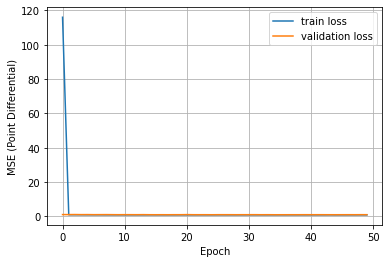

In [41]:
plot_loss(history)

In [42]:
print("Training MSE:", round(list(pd.DataFrame(history.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history.history)["val_loss"])[-1], 2))

Training MSE: 0.86
--------------------------------------------------
Validation MSE: 0.99


In [43]:
# testing

ff1_yhat = model.predict(X_test_std)
print('MSE FFNN 1:', np.mean(np.square((ff1_yhat - y_test_std)['point_differential'])))
ff1_mse = round(np.mean(np.square((ff1_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 644us/step
MSE FFNN 1: 0.9894804410761121


In [44]:
# testing (manual confirmation)

np.mean(np.square((ff1_yhat - y_test_std)['point_differential']))

0.9894804410761121

#### FFNN 2 <a id='FFNN2'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [45]:
def build_compile_tf_model_2(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 256,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.3,                  
          name = 'Dropout1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 128,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.3,                  
          name = 'Dropout2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 64,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [46]:
# Build a model
model2 = build_compile_tf_model_2(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [47]:
history2 = model2.fit(
    x=X_train_std, 
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
#     batch_size=12,
    epochs=50,
    verbose=0
)

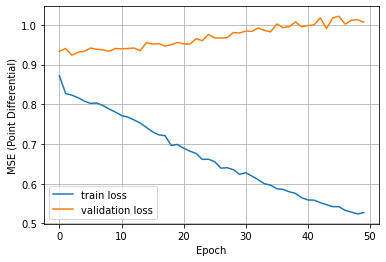

In [48]:
plot_loss(history2)

In [49]:
print("Training MSE:", round(list(pd.DataFrame(history2.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history2.history)["val_loss"])[-1], 2))

Training MSE: 0.53
--------------------------------------------------
Validation MSE: 1.01


In [50]:
# testing

ff2_yhat = model2.predict(X_test_std)
print('MSE FFNN 2:', np.mean(np.square((ff2_yhat - y_test_std)['point_differential'])))
ff2_mse = round(np.mean(np.square((ff2_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 563us/step
MSE FFNN 2: 0.9847452912226585


#### FFNN 3 <a id='FFNN3'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [51]:
def build_compile_tf_model_3(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 256,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                  
          name = 'Dropout1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 128,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                 
          name = 'Dropout2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 64,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [52]:
# Build a model
model3 = build_compile_tf_model_3(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [53]:
history3 = model3.fit(
    x=X_train_std, 
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
#     batch_size=12,
    epochs=50,
    verbose=0
)

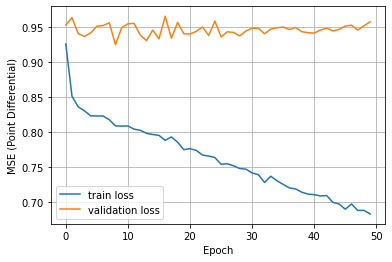

In [54]:
plot_loss(history3)

In [55]:
print("Training MSE:", round(list(pd.DataFrame(history3.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history3.history)["val_loss"])[-1], 2))

Training MSE: 0.68
--------------------------------------------------
Validation MSE: 0.96


In [56]:
# testing

ff3_yhat = model3.predict(X_test_std)
print('MSE FFNN 3:', np.mean(np.square((ff3_yhat - y_test_std)['point_differential'])))
ff3_mse = round(np.mean(np.square((ff3_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 587us/step
MSE FFNN 3: 0.9444808522629697


#### FFNN 4 <a id='FFNN4'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [57]:
def build_compile_tf_model_4(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 128,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                  # output dim
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 64,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 32,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [58]:
# Build a model
model4 = build_compile_tf_model_4(num_features = X_train_std.shape[1], learning_rate = 0.1)

In [59]:
history4 = model4.fit(
    x=X_train_std, 
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=50,
    verbose=0
)

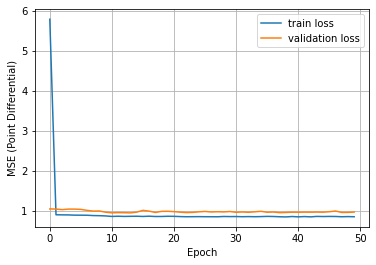

In [60]:
plot_loss(history4)

In [61]:
print("Training MSE:", round(list(pd.DataFrame(history4.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history4.history)["val_loss"])[-1], 2))

Training MSE: 0.86
--------------------------------------------------
Validation MSE: 0.97


In [62]:
# testing

ff4_yhat = model4.predict(X_test_std)
print('MSE FFNN 4:', np.mean(np.square((ff4_yhat - y_test_std)['point_differential'])))
ff4_mse = round(np.mean(np.square((ff4_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 589us/step
MSE FFNN 4: 0.9720891988396323


#### FFNN 5 <a id='FFNN5'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [63]:
def build_compile_tf_model_5(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                 
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [64]:
# Build a model
model5 = build_compile_tf_model_5(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [65]:
history5 = model5.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=50,
    verbose=0
)

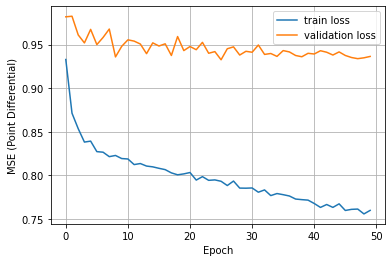

In [66]:
plot_loss(history5)

In [67]:
print("Training MSE:", round(list(pd.DataFrame(history5.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history5.history)["val_loss"])[-1], 2))

Training MSE: 0.76
--------------------------------------------------
Validation MSE: 0.94


In [68]:
# testing

ff5_yhat = model5.predict(X_test_std)
print('MSE FFNN 5:', np.mean(np.square((ff5_yhat - y_test_std)['point_differential'])))
ff5_mse = round(np.mean(np.square((ff5_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 556us/step
MSE FFNN 5: 0.9200068379555616


#### FFNN 6 <a id='FFNN6'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [69]:
def build_compile_tf_model_6(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [70]:
# Build a model
model6 = build_compile_tf_model_6(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [71]:
history6 = model6.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=50,
    verbose=0
)

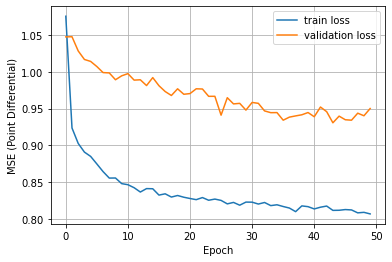

In [72]:
plot_loss(history6)

In [73]:
print("Training MSE:", round(list(pd.DataFrame(history6.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history6.history)["val_loss"])[-1], 2))

Training MSE: 0.81
--------------------------------------------------
Validation MSE: 0.95


In [74]:
# testing

ff6_yhat = model6.predict(X_test_std)
print('MSE FFNN 6:', np.mean(np.square((ff6_yhat - y_test_std)['point_differential'])))
ff6_mse = round(np.mean(np.square((ff6_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 446us/step
MSE FFNN 6: 0.9446962348125333


#### FFNN 7 <a id='FFNN7'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [75]:
def build_compile_tf_model_7(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [76]:
# Build a model
model7 = build_compile_tf_model_7(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [77]:
history7 = model7.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

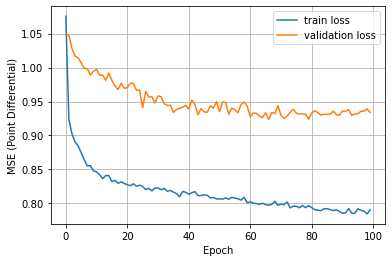

In [78]:
plot_loss(history7)

In [79]:
print("Training MSE:", round(list(pd.DataFrame(history7.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history7.history)["val_loss"])[-1], 2))

Training MSE: 0.79
--------------------------------------------------
Validation MSE: 0.93


In [80]:
# testing

ff7_yhat = model7.predict(X_test_std)
print('MSE FFNN 7:', np.mean(np.square((ff7_yhat - y_test_std)['point_differential'])))
ff7_mse = round(np.mean(np.square((ff7_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 436us/step
MSE FFNN 7: 0.9195940056339914


#### FFNN 8 <a id='FFNN8'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [81]:
def build_compile_tf_model_8(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',          
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                 
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',        
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',         
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [82]:
# Build a model
model8 = build_compile_tf_model_8(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [83]:
history8 = model8.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

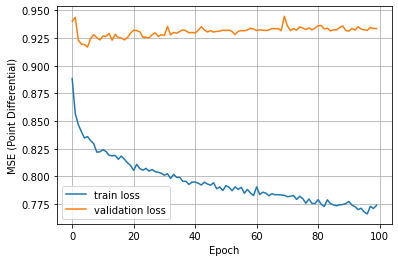

In [84]:
plot_loss(history8)

In [85]:
print("Training MSE:", round(list(pd.DataFrame(history8.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history8.history)["val_loss"])[-1], 2))

Training MSE: 0.77
--------------------------------------------------
Validation MSE: 0.93


In [86]:
# testing

ff8_yhat = model8.predict(X_test_std)
print('MSE FFNN 8:', np.mean(np.square((ff8_yhat - y_test_std)['point_differential'])))
ff8_mse = round(np.mean(np.square((ff8_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 457us/step
MSE FFNN 8: 0.9211901481352471


#### FFNN 9 <a id='FFNN9'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [87]:
def build_compile_tf_model_9(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [88]:
# Build a model
model9 = build_compile_tf_model_9(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [89]:
history9 = model9.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

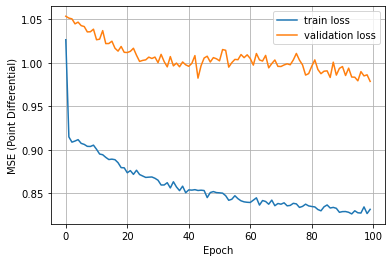

In [90]:
plot_loss(history9)

In [91]:
print("Training MSE:", round(list(pd.DataFrame(history9.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history9.history)["val_loss"])[-1], 2))

Training MSE: 0.83
--------------------------------------------------
Validation MSE: 0.98


In [92]:
# testing

ff9_yhat = model9.predict(X_test_std)
print('MSE FFNN 9:', np.mean(np.square((ff9_yhat - y_test_std)['point_differential'])))
ff9_mse = round(np.mean(np.square((ff9_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 490us/step
MSE FFNN 9: 0.9734320108457627


#### FFNN 10 <a id='FFNN10'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [93]:
def build_compile_tf_model_10(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [94]:
# Build a model
model10 = build_compile_tf_model_10(num_features = X_train_std.shape[1], learning_rate = 0.001)

In [95]:
history10 = model10.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

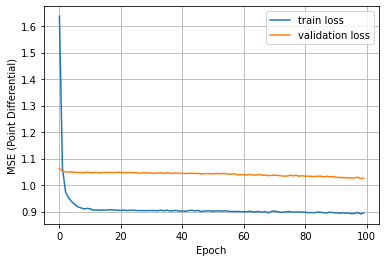

In [96]:
plot_loss(history10)

In [97]:
print("Training MSE:", round(list(pd.DataFrame(history10.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history10.history)["val_loss"])[-1], 2))

Training MSE: 0.9
--------------------------------------------------
Validation MSE: 1.03


In [98]:
# testing

ff10_yhat = model10.predict(X_test_std)
print('MSE FFNN 10:', np.mean(np.square((ff10_yhat - y_test_std)['point_differential'])))
ff10_mse = round(np.mean(np.square((ff10_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 486us/step
MSE FFNN 10: 1.022529139841294


#### FFNN 11 <a id='FFNN11'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [99]:
def build_compile_tf_model_11(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',         
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.9,                  # output dim
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',          
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.9,                  # output dim
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'sigmoid',        
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [100]:
# Build a model
model11 = build_compile_tf_model_11(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [101]:
history11 = model11.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

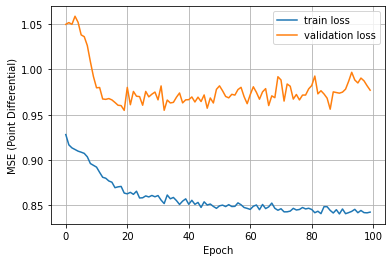

In [102]:
plot_loss(history11)

In [103]:
print("Training MSE:", round(list(pd.DataFrame(history11.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history11.history)["val_loss"])[-1], 2))

Training MSE: 0.84
--------------------------------------------------
Validation MSE: 0.98


In [104]:
# testing

ff11_yhat = model11.predict(X_test_std)
print('MSE FFNN 11:', np.mean(np.square((ff11_yhat - y_test_std)['point_differential'])))
ff11_mse = round(np.mean(np.square((ff11_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 476us/step
MSE FFNN 11: 0.9714744953971358


#### FFNN 12 <a id='FFNN12'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [105]:
def build_compile_tf_model_12(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 65,                   # output dim
          name = 'fc_1'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  # output dim
          name = 'Dropout_1'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',           
          units = 32,                   # output dim
          name = 'fc_2'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  # output dim
          name = 'Dropout_2'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 16,                   # output dim
          name = 'fc_3'
      ))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.7,                  # output dim
          name = 'Dropout_3'
      ))
    
    model.add(tf.keras.layers.Dense(
          activation = 'relu',          
          units = 8,                   # output dim
          name = 'fc_4'
      ))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )
    
    return model

In [106]:
# Build a model
model12 = build_compile_tf_model_12(num_features = X_train_std.shape[1], learning_rate = 0.01)

In [107]:
history12 = model12.fit(
    x=X_train_std,
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=100,
    verbose=0
)

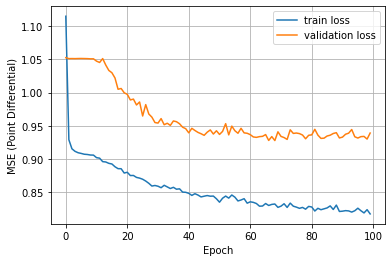

In [108]:
plot_loss(history12)

In [109]:
print("Training MSE:", round(list(pd.DataFrame(history12.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history12.history)["val_loss"])[-1], 2))

Training MSE: 0.82
--------------------------------------------------
Validation MSE: 0.94


In [110]:
# testing

ff12_yhat = model12.predict(X_test_std)
print('MSE FFNN 12:', np.mean(np.square((ff12_yhat - y_test_std)['point_differential'])))
ff12_mse = round(np.mean(np.square((ff12_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 443us/step
MSE FFNN 12: 0.9295632285444624


### Model D: Neural Network with Embeddings <a id='NNE'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis) <br>

#### NNE 1 <a id='NNE1'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [111]:
# Discretize the numerical input so it can work with embeddings
discretizer = tf.keras.layers.Discretization(num_bins = 10, epsilon = 0.01)
discretizer.adapt(X_train_std)

# Use the functional API in this case to have it work with the embedding layer
inputs = tf.keras.Input(shape = (X_train_std.shape[1],), name = 'Input')

x = discretizer(inputs)

embedding = tf.keras.layers.Embedding(input_dim = X_train_std.shape[1] + 1, output_dim = 10, name="embedding")(x)

pooling = tf.keras.layers.GlobalAveragePooling1D(name = 'pooling')(embedding)

dense_1 = tf.keras.layers.Dense(activation = 'relu', units = 130, name = 'Dense_1')(pooling)

dropout_1 = tf.keras.layers.Dropout(rate = 0.5, name = 'Dropout_1')(dense_1)
                      
dense_2 = tf.keras.layers.Dense(activation = 'relu', units = 65, name = 'Dense_2')(dropout_1)
                      
dropout_2 = tf.keras.layers.Dropout(rate = 0.5, name = 'Dropout_2')(dense_2)

dense_3 = tf.keras.layers.Dense(activation = 'relu', units = 32, name = 'Dense_3')(dropout_2)

output = tf.keras.layers.Dense(activation = None, units = 1, name = 'output')(dense_3)

# instantiate the model
model_embedding = tf.keras.models.Model(inputs = inputs, outputs = output)

In [112]:
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01)
model_embedding.compile(optimizer=optimizer, loss = 'mse')

In [113]:
tf.random.set_seed(0)
np.random.seed(0)
history_embedding = model_embedding.fit(
    X_train_std, 
    y_train_std,
    epochs=50, 
    validation_data=(X_val_std, y_val_std),
    verbose = 0
)

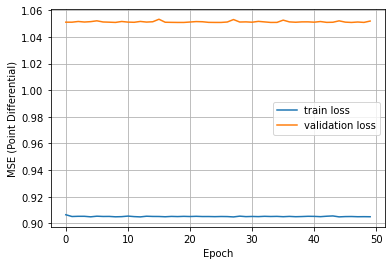

In [114]:
plot_loss(history_embedding)

In [115]:
print("Training MSE:", round(list(pd.DataFrame(history_embedding.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history_embedding.history)["val_loss"])[-1], 2))

Training MSE: 0.9
--------------------------------------------------
Validation MSE: 1.05


In [116]:
# testing

embedding_yhat = model_embedding.predict(X_test_std)
print('MSE Embeddings:', np.mean(np.square((embedding_yhat - y_test_std)['point_differential'])))
embedding_mse = round(np.mean(np.square((embedding_yhat - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 568us/step
MSE Embeddings: 1.048339970845972


### Model E: Convolutional Neural Network (CNN) <a id='CNN'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis) <br>

#### CNN 1 <a id='CNN1'></a> 
[jump to top of Analysis](#top_of_analysis)<br>

In [117]:
def build_compile_tf_model_cnn(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. While this is intended for neural
    # networks (which may have multiple layers), we want just a single layer for
    # linear regression.
    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,1,),
         name='Input'
    ))
    
    ## first convolution ##
    #######################
    model.add(tf.keras.layers.Conv1D(
            filters=128,
            kernel_size=4,
            padding='same',
            activation='relu', 
            name = "Convolution_1"))
    
    model.add(tf.keras.layers.Dropout(
          rate = 0.5,                  # output dim
          name = 'Dropout_1'
      ))
    
    # add maxpooling
    model.add(tf.keras.layers.MaxPooling1D(
        pool_size=2, name = "Maxpool_1"))
    
    ## second convolution ##
    ########################
    model.add(tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=4,
        padding='same',
        activation='relu',
        name = "Convolution_2"))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5, 
        name = "Dropout_2"))

    # add maxpooling
    model.add(tf.keras.layers.MaxPooling1D(
        pool_size=2, 
        name = "Maxpool_2"))

    ## third convolution ##
    #######################
    model.add(tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=5,
        padding='same',
        activation='relu',
        name = "Convolution_3"))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5, 
        name = "Dropout_3"))

    # add maxpooling
    model.add(tf.keras.layers.MaxPooling1D(
        pool_size=2, 
        name = "Maxpool_3"))
    
    model.add(tf.keras.layers.Dense(        
          units = 1,                   # output dim
          name = 'output'
      ))
    
    # We need to choose an optimizer. We'll use Adamax
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse', 
        metrics = ['accuracy'],
    )
    
    return model

In [118]:
# Build a model
model_cnn = build_compile_tf_model_cnn(num_features = X_train_std.shape[1], learning_rate = 0.1)

In [119]:
history_cnn = model_cnn.fit(
    x=X_train_std, 
    y=y_train_std,
    validation_data=(X_val_std, y_val_std),
    epochs=50,
    verbose=0
)

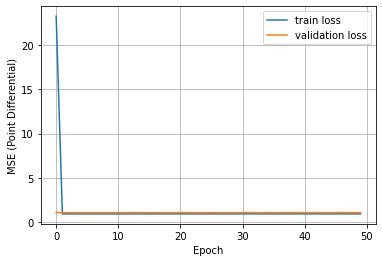

In [120]:
plot_loss(history_cnn)

In [121]:
print("Training MSE:", round(list(pd.DataFrame(history_cnn.history)["loss"])[-1], 2))
print("-"*50)
print("Validation MSE:", round(list(pd.DataFrame(history_cnn.history)["val_loss"])[-1], 2))

Training MSE: 0.91
--------------------------------------------------
Validation MSE: 1.05


In [122]:
# testing

cnn_yhat = model_cnn.predict(X_test_std)
print('MSE CNN:', np.mean(np.square((cnn_yhat[:,0,:] - y_test_std)['point_differential'])))
cnn_mse = round(np.mean(np.square((cnn_yhat[:,0,:] - y_test_std)['point_differential'])),2)

125/125 [==============================] - 0s 3ms/step
MSE CNN: 1.048408449373261


### Model F: Recurrent Neural Network (RNN) <a id='RNN'></a> 
[jump to top](#top) | [jump to top of Analysis](#top_of_analysis) <br>

#### See the LSTM Notebook for all the work done with the more advanced model.

---
## Step 7: Evaluation <a id='evaluation'></a> 
[jump to top](#top)<br>

In [123]:
base_line_eval = ["Baseline", "MSE", 0.9, 1.05, baseline_mse['point_differential']]
LR_1_eval = ["LR 1", "MSE", 0.82, 0.93, short_reg_mse]
LR_2_eval = ["LR 2", "MSE", 0.82, 0.93, medium_reg_mse]
LR_3_eval = ["LR 3", "MSE", 0.8, 0.92, full_reg_mse]
FFNN_1_eval = ["FFNN 1", "MSE", 0.86, 0.99, ff1_mse]
FFNN_2_eval = ["FFNN 2", "MSE", 0.53, 1.01, ff2_mse]
FFNN_3_eval = ["FFNN 3", "MSE", 0.68, 0.96, ff3_mse]
FFNN_4_eval = ["FFNN 4", "MSE", 0.86, 0.97, ff4_mse]
FFNN_5_eval = ["FFNN 5", "MSE", 0.76, 0.94, ff5_mse]
FFNN_6_eval = ["FFNN 6", "MSE", 0.81, 0.95, ff6_mse]
FFNN_7_eval = ["FFNN 7", "MSE", 0.79, 0.93, ff7_mse]
FFNN_8_eval = ["FFNN 8", "MSE", 0.77, 0.93, ff8_mse]
FFNN_9_eval = ["FFNN 9", "MSE", 0.83, 0.98, ff9_mse]
FFNN_10_eval = ["FFNN 10", "MSE", 0.9, 1.03, ff10_mse]
FFNN_11_eval = ["FFNN 11", "MSE", 0.84, 0.98, ff11_mse]
FFNN_12_eval = ["FFNN 12", "MSE", 0.82, 0.94, ff12_mse]
NNE_1_eval = ["NNE 1", "MSE", 0.9, 1.05, embedding_mse]
CNN_1_eval = ["CNN 1", "MSE", 0.91, 1.05, cnn_mse]

pd.DataFrame([base_line_eval, 
              LR_1_eval, 
              LR_2_eval, 
              LR_3_eval, 
              FFNN_1_eval, 
              FFNN_2_eval, 
              FFNN_3_eval, 
              FFNN_4_eval,
              FFNN_5_eval,
              FFNN_6_eval,
              FFNN_7_eval,
              FFNN_8_eval,
              FFNN_9_eval,
              FFNN_10_eval,
              FFNN_11_eval,
              FFNN_12_eval,
              NNE_1_eval, 
              CNN_1_eval], 
             columns = ["Model",
                        "loss function", 
                        "Training loss", 
                        "Validation loss",
                        "Test loss"])

,Model,loss function,Training loss,Validation loss,Test loss
0,Baseline,MSE,0.90,1.05,1.05
1,LR 1,MSE,0.82,0.93,0.92
2,LR 2,MSE,0.82,0.93,0.91
3,LR 3,MSE,0.80,0.92,0.91
4,FFNN 1,MSE,0.86,0.99,0.99
5,FFNN 2,MSE,0.53,1.01,0.98
6,FFNN 3,MSE,0.68,0.96,0.94
7,FFNN 4,MSE,0.86,0.97,0.97
8,FFNN 5,MSE,0.76,0.94,0.92
9,FFNN 6,MSE,0.81,0.95,0.94
